# Settings

### Autoreload of ipynb

In [133]:
%reload_ext autoreload
%autoreload 2

### Changing the path to the main directories path

In [134]:
import os
os.chdir(r"C:\Users\amilion\Documents\GitHub\CNRL-Cortical-Column\src")
os.getcwd()

'C:\\Users\\amilion\\Documents\\GitHub\\CNRL-Cortical-Column\\src'

# Imports

In [135]:
from conex import *
from pymonntorch import *

from matplotlib import pyplot as plt

from L56.RefrenceFrames import RefrenceFrame
from L56.stimuli.current_base import RandomInputCurrent
from L56.synapse.vDistributor import ManualVCoder
from InputLayer.DataLoaderLayer import DataLoaderLayer
from InputLayer.synapse.LocationCoder import LocationCoder
from L423.network.SetTarget import SetTarget

from L56.tools.visualization import refrence_frame_raster
from L423.tools.visualize import show_filters

# Configs

In [136]:
HIGHER_LAYER_DIM = 16 
REFRENCE_FRAME_DIM = 23
REFRENCE_INH_DIM = 15
ITERATIONS = 240
REST_INTERVAL = 20
TEST_ITERATIONS = 100
SCREEN_SHOT_PATH = "C:\\Users\\amilion\\Desktop\\develop\\python\\NS\\records\\L5.6"

# Defining emty DataLoader

In [137]:
class EmptyDataLoader():
    def __init__(self):
        self.dataset = torch.zeros(2, 15, 15)
        super().__init__()

dl = EmptyDataLoader()
dl.dataset

tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      

# Defining targets

In [138]:
target = torch.Tensor([1, 1])

# Initializing the Network

In [139]:
net = Neocortex(index=True, dt=1, dtype=torch.float32, behavior = prioritize_behaviors(
    [
        Payoff(initial_payoff = 1),
        Dopamine(tau_dopamine = 5),
    ]
    ) | {5 : SetTarget(target = target), 601 : Recorder(["dopamine"])})

# Neuron Groups

### Defining L23

In [140]:

higher_layer = NeuronGroup(
    net=net,
    size=NeuronDimension(depth=1, height=HIGHER_LAYER_DIM, width=HIGHER_LAYER_DIM),
    behavior=prioritize_behaviors(
        [
            SimpleDendriteStructure(),
            SimpleDendriteComputation(),
            SpikeTrace(tau_s = 20, offset = 0),
            NeuronAxon(),
        ]
    )
    | (
        {
            250: RandomInputCurrent(k=2, rest_interval=20, prob_to_spike=0.2, intensity=1, T=50),
            # 600: Recorder(["I", "v"]),
            603: EventRecorder(["spikes"]),
        }
    ),
)

L23 = Layer(
    net=net, 
    neurongroups=[higher_layer], 
    input_ports={"input": (None, [Port(object=higher_layer, label=None)])}, 
    output_ports={"output":(None, [Port(object=higher_layer, label=None)])}
)

### Defining L56

In [141]:
L56 = RefrenceFrame(
    net=net, 
    k=5, 
    refrence_frame_side=REFRENCE_FRAME_DIM, 
    inhibitory_size=REFRENCE_INH_DIM,
    competize=True).build_layer()

### Defining InputLayer

In [142]:
InputLayer = DataLoaderLayer(
    net=net, 
    data_loader=dl, 
    widnow_size=1, 
    saccades_on_each_image=2, 
    rest_interval=20, 
    iterations=ITERATIONS).build_data_loader()

# Synapses

### Without Learning

In [143]:
Inp_to_L56 = Synapsis(
    net = net,
    src = InputLayer,
    dst = L56,
    input_port = "data_out",
    output_port = "input",
    synapsis_behavior=prioritize_behaviors([
        SynapseInit(),]) | {
        275: LocationCoder()
    },
    synaptic_tag="Proximal"
)

### With Learning

In [144]:
L23_to_L56 = Synapsis(
    net=net,
    src=L23,
    dst=L56,
    input_port="output",
    output_port="input",
    synaptic_tag="Apical, exi",
    synapsis_behavior=prioritize_behaviors(
        [
            SynapseInit(), 
            SimpleDendriticInput(),
            WeightInitializer(mode="normal(0.05, 0.01)"),
            SimpleSTDP(w_min=0, w_max=100, a_plus=1, a_minus=0.0008)
        ]
    )
)

L56_to_L23 = Synapsis(
    net=net,
    src=L56,
    dst=L23,
    input_port="output",
    output_port="input",
    synaptic_tag="Apical, exi",
    synapsis_behavior=prioritize_behaviors(
        [
            SynapseInit(), 
            SimpleDendriticInput(),
            WeightInitializer(mode="normal(0.05, 0.01)"),
            SimpleSTDP(w_min=0, w_max=10, a_plus=1, a_minus=0.0008)
        ]
    )
)

# Simulating the network

In [145]:
net.initialize()

Network['Neocortex'](Neurons: tensor(2917)|8 groups, Synapses: tensor(2158545)|26 groups){1:TimeResolution(dt=1,)5:SetTarget(target=tensor([1., 1.]),)100:Payoff(initial_payoff=1,)120:Dopamine(tau_dopamine=5,initial_dopamine_concentration=None,)601:Recorder(variables=None,gap_width=0,max_length=None,auto_annotate=True,tag=None,arg_0=['dopamine'],)}
NeuronGroup['NeuronGroup_1', 'NeuronGroup', 'ng'](256){0:NeuronDimension(depth=1,height=16,width=16,input_patterns=None,)220:SimpleDendriteStructure(Proximal_max_delay=1,Distal_max_delay=1,Apical_max_delay=None,proximal_min_delay=0,distal_min_delay=0,apical_min_delay=None,)240:SimpleDendriteComputation(I_tau=None,apical_provocativeness=None,distal_provocativeness=None,)250:RandomInputCurrent(k=2,rest_interval=20,prob_to_spike=0.2,intensity=1,T=50,)360:SpikeTrace(tau_s=20,offset=0,)380:NeuronAxon(max_delay=1,proximal_min_delay=0,distal_min_delay=0,apical_min_delay=0,have_trace=None,)603:EventRecorder(variables=None,gap_width=0,max_length=None,

In [146]:
L23_to_L56.synapses[1].weights

tensor([[0.0348, 0.0424, 0.0549,  ..., 0.0619, 0.0459, 0.0294],
        [0.0426, 0.0506, 0.0720,  ..., 0.0559, 0.0516, 0.0540],
        [0.0607, 0.0356, 0.0517,  ..., 0.0619, 0.0676, 0.0411],
        ...,
        [0.0579, 0.0578, 0.0549,  ..., 0.0449, 0.0681, 0.0257],
        [0.0430, 0.0435, 0.0642,  ..., 0.0475, 0.0430, 0.0347],
        [0.0564, 0.0444, 0.0535,  ..., 0.0388, 0.0234, 0.0416]])

In [147]:
net.simulate_iterations(ITERATIONS)

tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(176)
tensor(132)
tensor(264)
tensor(308)
tensor(220)
tensor(0)
tensor(0)
tensor(0)
tensor(1100)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(924)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1100)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1100)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1100)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1056)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1100)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1100)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1100)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1100)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1100)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1100)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1100)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1100)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1100)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1100)
ten

4190.54651260376

In [148]:
a = torch.tensor([1, 1])
a = torch.tensor([torch.nan, torch.nan])
torch.isnan(a[0])

tensor(True)

# Visualizing

### Finding the refrence Frames

In [149]:
refrences = []

for refrence in L56.neurongroups:
    if 'RefrenceFrame' in refrence.tags:
        refrences.append(refrence)

### Saving the plots

In [150]:
# refrence_frame_raster(
#     refrence_frame=refrences[1],
#     lib = SCREEN_SHOT_PATH,
#     last_itr=140,
#     step=1
# )

## Direction of Movement Vector

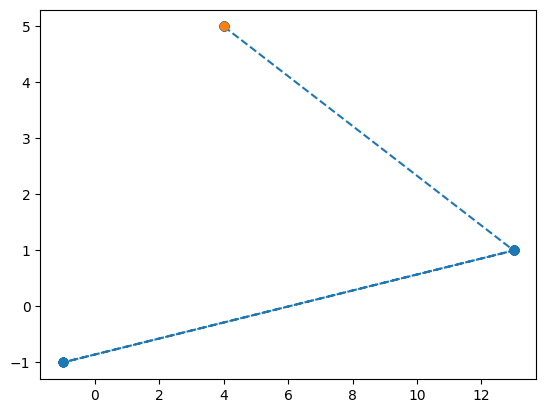

In [151]:
pos_x = InputLayer.neurongroups[0]["focus_loc", 0][:125,0]
pos_y = InputLayer.neurongroups[0]["focus_loc", 0][:125,1]

pos_x, pos_y
plt.plot(pos_x, pos_y, '--o')
plt.plot(pos_x[0], pos_y[0], 'o')

In [152]:
L23_to_L56.synapses[1].weights

tensor([[0.0348, 0.0424, 0.0549,  ..., 0.0619, 0.0459, 0.0294],
        [0.0426, 0.0506, 0.0720,  ..., 0.0559, 0.0516, 0.0540],
        [0.0607, 0.0356, 0.0517,  ..., 0.0619, 0.0676, 0.0411],
        ...,
        [0.0579, 0.0578, 0.0549,  ..., 0.0449, 0.0681, 0.0257],
        [0.0430, 0.0435, 0.0642,  ..., 0.0475, 0.0430, 0.0347],
        [0.0564, 0.0444, 0.0535,  ..., 0.0388, 0.0234, 0.0416]])

## Pattern Location Binding Test

In [153]:
from L56.tools.model_evaluation import cosine_similarity

In [154]:
for idx, refrence in enumerate(refrences):
    print(idx, cosine_similarity(refrence, 45, 125))

0 tensor(0.)
1 tensor(0.)
2 tensor(0.)
3 tensor(0.7200)
4 tensor(0.)
